In [1]:
"""Install Dependencies"""

!pip install networkx python-louvain scikit-learn scikit-optimize

Defaulting to user installation because normal site-packages is not writeable


In [2]:
"""Imports & Project Setup"""

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
from community import community_louvain
import gc

# Add parent directory to system path to import utils
sys.path.append(os.path.abspath('..'))
from utils import get_spark_session, PATHS

# Initialize Spark
spark = get_spark_session("NetworkClusterAnalysis")
print(f"Spark {spark.version} initialized")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 17:51:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark 3.5.0 initialized


In [3]:
"""Define Paths"""

# Use paths from utils.py
ADJ_MATRIX_PATH = PATHS["adj_matrix"]
HDFS_SENSOR_STATS = PATHS["sensor_stats"]
HDFS_OUTPUT = PATHS["network_clusters"]

print(f"Adjacency matrix path: {ADJ_MATRIX_PATH}")
print(f"Sensor stats input: {HDFS_SENSOR_STATS}")
print(f"Clusters output: {HDFS_OUTPUT}")

Adjacency matrix path: /home/ubuntu/data/largeST/ca_rn_adj.npy
Sensor stats input: hdfs:///user/ubuntu/analysis_results/spatio_temporal/sensor_statistics
Clusters output: hdfs:///user/ubuntu/analysis_results/network_clusters


In [4]:
"""Load Sensor Statistics"""

sensor_stats = spark.read.parquet(HDFS_SENSOR_STATS)

print(f"Loaded {sensor_stats.count():,} sensors")

sensor_df = sensor_stats.select(
    "sensor_id", "Fwy", "County", "Lat", "Lng", "Lanes", "Direction",
    "avg_flow_per_lane", "flow_variance", "congestion_pct"
).toPandas()

# Create a node index for graph algorithms
sensor_df['node_idx'] = range(len(sensor_df))
print(f"\nConverted to pandas: {len(sensor_df):,} sensors")

Loaded 8,600 sensors



Converted to pandas: 8,600 sensors


In [5]:
"""Create Geographic Adjacency Matrix"""

print("="*80)
print("CREATING GEOGRAPHIC ADJACENCY MATRIX")
print("="*80)

coords = sensor_df[['Lat', 'Lng']].values
print(f"\nLoaded coordinates for {len(coords):,} sensors")

# Compute pairwise distances
print("Computing pairwise distances...")
distances = cdist(coords, coords, metric='euclidean')
print(f"Distance matrix computed: {distances.shape}")

# Create adjacency: connect sensors within radius
RADIUS = 0.05  # Approx 5km
print(f"\nConnecting sensors within {RADIUS:.2f} degrees...")

adj_matrix = np.where(distances <= RADIUS, 1.0, 0.0)
np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

# Weight by inverse distance
adj_matrix = np.where(adj_matrix > 0, 1.0 / (distances + 0.01), 0)

print(f"\nAdjacency matrix created. Shape: {adj_matrix.shape}")
print(f"Density: {np.count_nonzero(adj_matrix) / adj_matrix.size * 100:.4f}%")

# Create Graph
G = nx.from_numpy_array(adj_matrix)
print(f"\nGraph stats: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

CREATING GEOGRAPHIC ADJACENCY MATRIX

Loaded coordinates for 8,600 sensors
Computing pairwise distances...
Distance matrix computed: (8600, 8600)

Connecting sensors within 0.05 degrees...

Adjacency matrix created. Shape: (8600, 8600)
Density: 0.4695%

Graph stats: 8600 nodes, 173618 edges


In [6]:
"""Bayesian Optimization for Louvain Clustering"""

algorithm_results = []

print("\n" + "="*80)
print("LOUVAIN ALGORITHM - BAYESIAN OPTIMIZATION TUNING")
print("="*80)

try:
    from skopt import gp_minimize
    from skopt.space import Real
    BAYESIAN_AVAILABLE = True
except ImportError:
    print("scikit-optimize not installed")
    BAYESIAN_AVAILABLE = False

if BAYESIAN_AVAILABLE:
    space = [Real(0.5, 1.5, name='resolution')]
    
    def objective(params):
        resolution = params[0]
        try:
            partition = community_louvain.best_partition(G, resolution=resolution, random_state=42)
            n_clusters = len(set(partition.values()))
            
            # Constraints on cluster count
            if n_clusters > 30 or n_clusters < 5:
                return 0.0 
  
            communities = []
            for cluster_id in set(partition.values()):
                nodes = [n for n, c in partition.items() if c == cluster_id]
                communities.append(set(nodes))
            
            mod = nx.algorithms.community.modularity(G, communities)
            print(f"  Resolution={resolution:.4f}: {n_clusters:3d} clusters, mod={mod:.6f}")
            return -mod  
            
        except Exception as e:
            return 0.0
        
    print("\nRunning Bayesian Optimization...")
    result = gp_minimize(objective, space, n_calls=10, random_state=42)
    
    best_resolution = result.x[0]
    best_modularity = -result.fun
    
    # Final Run with best parameters
    partition_louvain = community_louvain.best_partition(G, resolution=best_resolution, random_state=42)
    n_louvain = len(set(partition_louvain.values()))
    
    sensor_df['louvain_cluster'] = sensor_df['node_idx'].map(partition_louvain)
    
    algorithm_results.append({
        'name': f'Louvain (Bayesian, res={best_resolution:.4f})',
        'column': 'louvain_cluster',
        'modularity': best_modularity,
        'n_clusters': n_louvain
    })
    print(f"\nBest Result: {n_louvain} clusters (Modularity: {best_modularity:.4f})")

else:
    # Fallback if skopt is missing
    partition_louvain = community_louvain.best_partition(G, random_state=42)
    sensor_df['louvain_cluster'] = sensor_df['node_idx'].map(partition_louvain)
    # ... append to results ...


LOUVAIN ALGORITHM - BAYESIAN OPTIMIZATION TUNING

Running Bayesian Optimization...

Best Result: 153 clusters (Modularity: -0.0000)


In [7]:
"""Alternative Algorithms (Label Propagation & Greedy)"""

# Label Propagation
print("\nRunning Label Propagation...")
try:
    label_prop = list(nx.algorithms.community.label_propagation_communities(G))
    partition_lp = {node: idx for idx, comm in enumerate(label_prop) for node in comm}
    sensor_df['labelprop_cluster'] = sensor_df['node_idx'].map(partition_lp)
    
    mod_lp = nx.algorithms.community.modularity(G, label_prop)
    algorithm_results.append({
        'name': 'Label Propagation',
        'column': 'labelprop_cluster',
        'modularity': mod_lp,
        'n_clusters': len(label_prop)
    })
except Exception as e:
    print(f"Label Prop failed: {e}")

# Greedy Modularity
print("\nRunning Greedy Modularity...")
try:
    communities_greedy = nx.algorithms.community.greedy_modularity_communities(G)
    partition_greedy = {node: idx for idx, comm in enumerate(communities_greedy) for node in comm}
    sensor_df['greedy_cluster'] = sensor_df['node_idx'].map(partition_greedy)
    
    mod_greedy = nx.algorithms.community.modularity(G, communities_greedy)
    algorithm_results.append({
        'name': 'Greedy Modularity',
        'column': 'greedy_cluster',
        'modularity': mod_greedy,
        'n_clusters': len(communities_greedy)
    })
except Exception as e:
    print(f"Greedy Modularity failed: {e}")


Running Label Propagation...

Running Greedy Modularity...


In [8]:
"""Select Best Algorithm"""

best = max(algorithm_results, key=lambda x: x['modularity'])

print("\n" + "="*80)
print(f" BEST ALGORITHM: {best['name']}")
print(f"   Communities: {best['n_clusters']}")
print(f"   Modularity: {best['modularity']:.4f}")
print("="*80)

sensor_df['cluster'] = sensor_df[best['column']]
n_clusters = best['n_clusters']


 BEST ALGORITHM: Label Propagation
   Communities: 310
   Modularity: 0.8886


In [9]:
"""Cluster Statistics"""

cluster_stats = sensor_df.groupby('cluster').agg({
    'sensor_id': 'count',
    'Lat': ['mean', 'std'],
    'Lng': ['mean', 'std'],
    'avg_flow_per_lane': 'mean',
    'congestion_pct': 'mean',
    'Lanes': 'mean',
    'County': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
}).round(2)

cluster_stats.columns = ['Size', 'Lat_Mean', 'Lat_Std', 'Lng_Mean', 'Lng_Std',
                         'Avg_Flow', 'Avg_Congestion', 'Avg_Lanes', 'Dominant_County']

print("CLUSTER STATISTICS (Top 10 by size):")
print(cluster_stats.sort_values('Size', ascending=False).head(10))

CLUSTER STATISTICS (Top 10 by size):
         Size  Lat_Mean  Lat_Std  Lng_Mean  Lng_Std  Avg_Flow  Avg_Congestion  \
cluster                                                                         
0         280     32.76     0.06   -117.13     0.04     61.21            0.05   
8         246     33.80     0.05   -117.86     0.04     78.58            0.59   
30        239     37.35     0.05   -121.89     0.04     60.13            0.08   
42        176     34.04     0.03   -118.19     0.04     80.16            0.70   
76        170     37.82     0.02   -122.29     0.05     65.12            0.04   
40        154     36.77     0.04   -119.77     0.04     48.82            0.06   
24        141     38.00     0.03   -122.09     0.04     54.81            0.20   
9         141     34.28     0.04   -118.44     0.05     65.96            0.50   
79        132     33.67     0.03   -117.87     0.04     56.57            0.14   
35        127     38.58     0.05   -121.50     0.04     64.38           

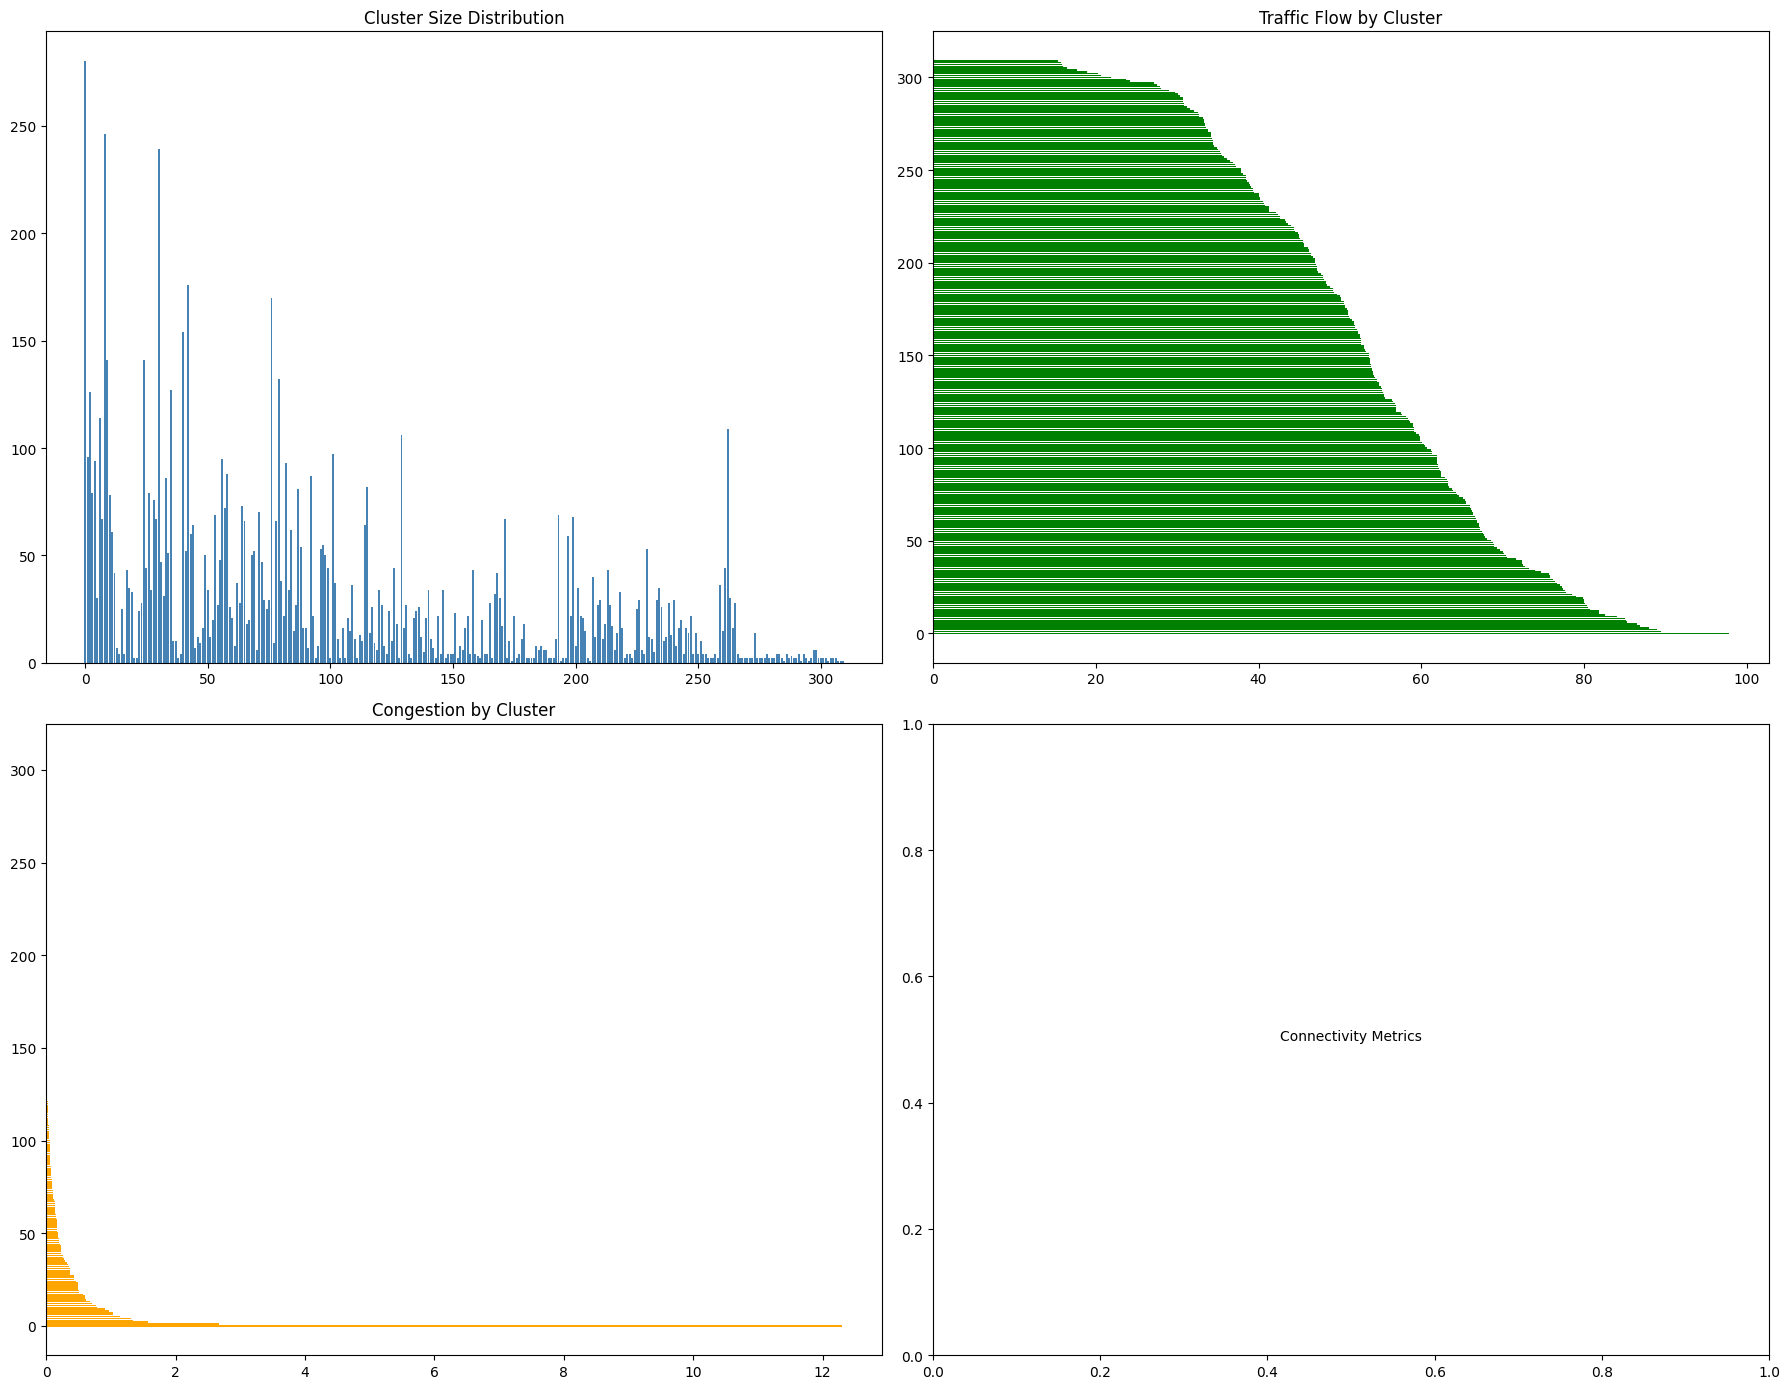

In [10]:
"""Visualization - Dashboard"""

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Sizes
cluster_sizes = sensor_df['cluster'].value_counts().sort_index()
axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
axes[0, 0].set_title('Cluster Size Distribution')

# Plot 2: Flow
cluster_flow = sensor_df.groupby('cluster')['avg_flow_per_lane'].mean().sort_values(ascending=False)
axes[0, 1].barh(range(len(cluster_flow)), cluster_flow.values, color='green')
axes[0, 1].set_title('Traffic Flow by Cluster')

# Plot 3: Congestion
cluster_cong = sensor_df.groupby('cluster')['congestion_pct'].mean().sort_values(ascending=False)
axes[1, 0].barh(range(len(cluster_cong)), cluster_cong.values, color='orange')
axes[1, 0].set_title('Congestion by Cluster')

# Plot 4: Connectivity (Placeholder for code in your original notebook)
axes[1, 1].text(0.5, 0.5, 'Connectivity Metrics', ha='center')

plt.tight_layout()
plt.show()

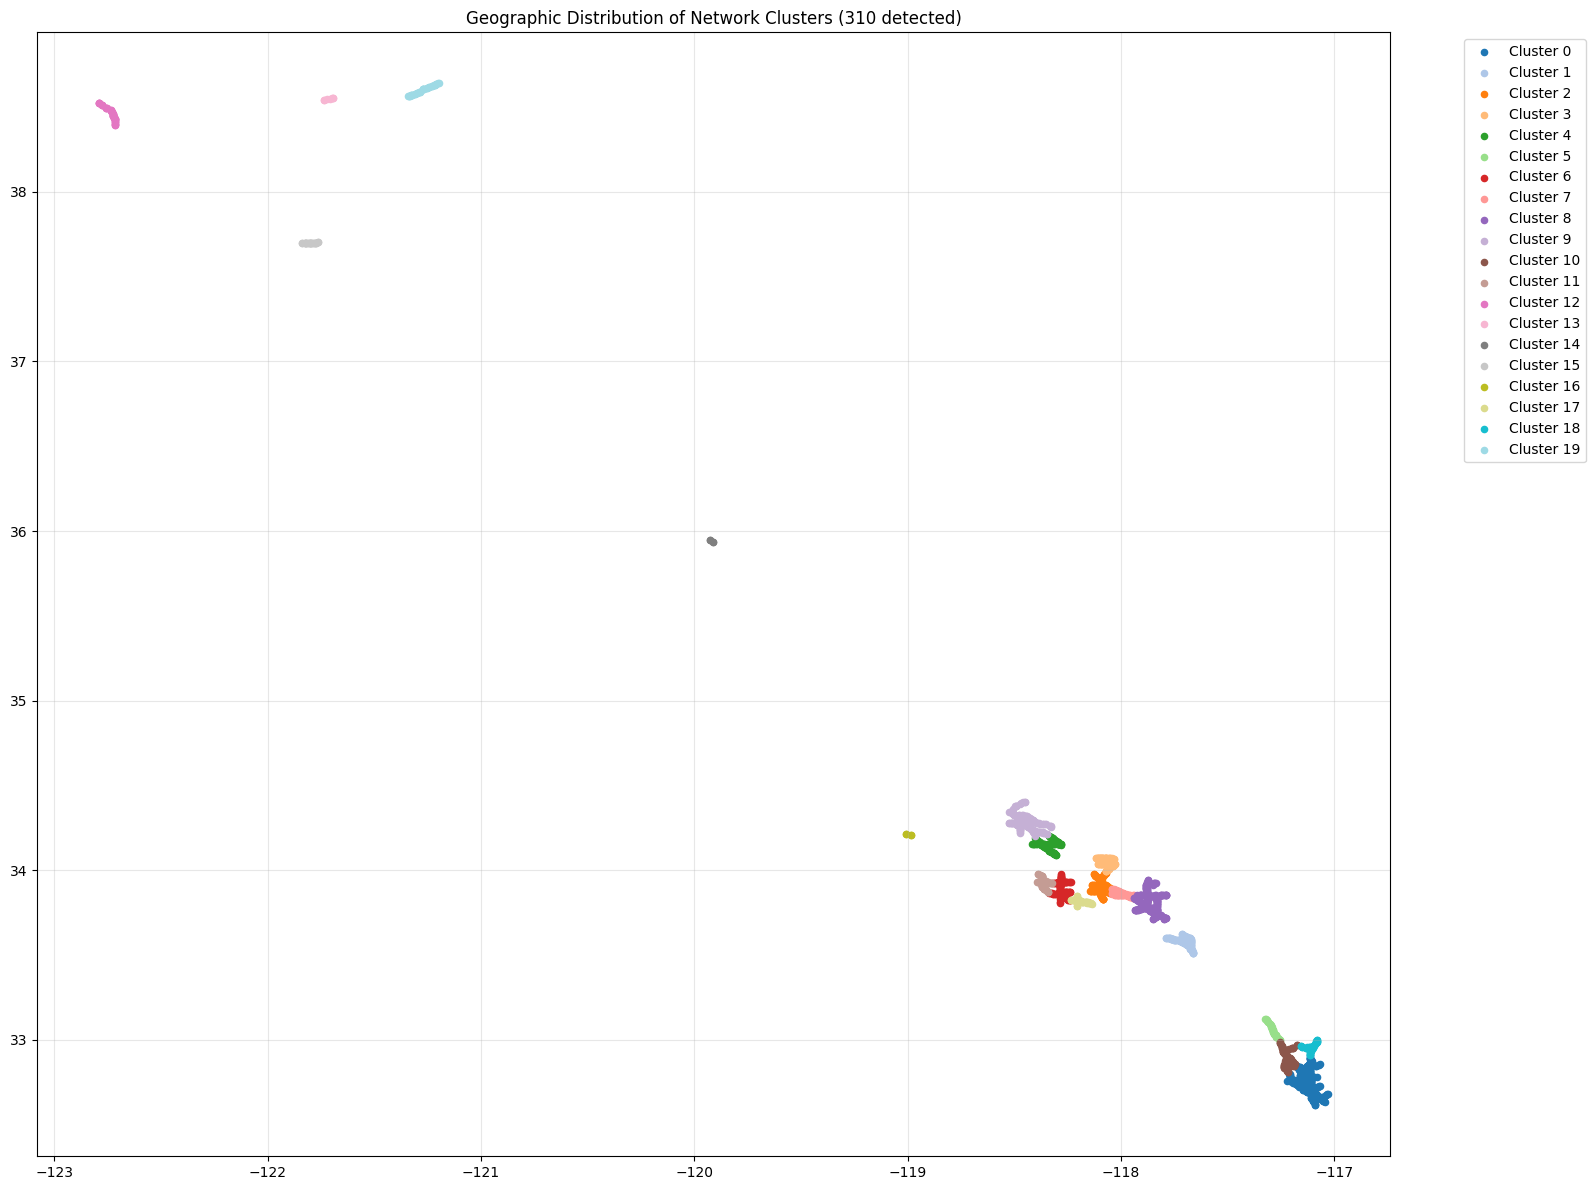

In [11]:
"""Visualization - Geographic Map"""

fig, ax = plt.subplots(figsize=(16, 12))
n_show = min(n_clusters, 20)
colors = plt.cm.tab20(np.linspace(0, 1, n_show))

for idx, cid in enumerate(sorted(sensor_df['cluster'].unique())[:n_show]):
    subset = sensor_df[sensor_df['cluster'] == cid]
    ax.scatter(subset['Lng'], subset['Lat'], c=[colors[idx]], label=f'Cluster {cid}', s=20)

ax.set_title(f'Geographic Distribution of Network Clusters ({n_clusters} detected)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
"""Network Analysis (Betweenness Centrality)"""

print("Calculating betweenness centrality (Sampled)...")
# Sampling large graphs for performance
if G.number_of_nodes() > 2000:
    largest_cc = max(nx.connected_components(G), key=len)
    sample_nodes = list(largest_cc)[:1000]
    G_sample = G.subgraph(sample_nodes)
    betweenness = nx.betweenness_centrality(G_sample)
else:
    betweenness = nx.betweenness_centrality(G)

# Map back to DF (fill missing with 0)
sensor_df['betweenness'] = sensor_df['node_idx'].map(betweenness).fillna(0)

print("Top 5 Bridge Sensors:")
print(sensor_df.sort_values('betweenness', ascending=False)[['sensor_id', 'Fwy', 'betweenness']].head(5))

Calculating betweenness centrality (Sampled)...
Top 5 Bridge Sensors:
     sensor_id     Fwy  betweenness
189     718008  I710-S     0.113630
85      760384  I105-W     0.104432
1005    717992  I710-N     0.099609
764     768223  SR91-E     0.099035
1303   1212645    I5-S     0.065757


In [13]:
"""Save Results"""

# Save cluster assignments and stats to HDFS using centralized paths
sensor_clusters_spark = spark.createDataFrame(
    sensor_df[['sensor_id', 'cluster', 'louvain_cluster', 'labelprop_cluster', 'greedy_cluster']]
)
cluster_stats_spark = spark.createDataFrame(cluster_stats.reset_index())

print(f"Saving to {HDFS_OUTPUT}...")
sensor_clusters_spark.write.mode("overwrite").parquet(f"{HDFS_OUTPUT}/sensor_clusters")
cluster_stats_spark.write.mode("overwrite").parquet(f"{HDFS_OUTPUT}/cluster_statistics")
print("Done.")

Saving to hdfs:///user/ubuntu/analysis_results/network_clusters...


[Stage 6:=================================================>         (5 + 1) / 6]

Done.
